In [1]:
# Import statements 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import string
import datetime
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import f1_score

In [2]:
# Load data
train_feats = pd.read_csv('train-dev-test/train_cleaned_features.csv', delimiter=',', encoding="utf-8")
dev_feats = pd.read_csv('train-dev-test/dev_cleaned_features.csv', delimiter=',', encoding="utf-8")
test_feats = pd.read_csv('train-dev-test/test_cleaned_features.csv', delimiter=',', encoding="utf-8")

# Clear whitespace
train_feats.columns = train_feats.columns.str.strip()

/opt/anaconda3/envs/prop-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Dropping stuff!

# Drop all rows where time is NA?
print("Old length: ", len(train_feats))
train_feats = train_feats[train_feats['time'].notna()]
print("New length: ", len(train_feats))

# Just drop hashtags for now, too difficult for M3 to deal with
train_feats = train_feats.drop(['hashtags'], axis=1)

Old length:  3515562
New length:  3515538


In [4]:
# View the dataframes
train_feats.head(5)
#train_feats.columns                                        

,text,place,user_location,followers_count,retweet_count,favorite_count,weekday,month,day,time,...,num_present,trump_present,hashtag_present,covid,vaccine,profanity_present,emoji_present,url_present,question_exclamation_present,sentiment
0,Pretty much any corona virus germ that wants t...,NaN,PG County,478,0,10,Thu,Mar,19.0,19:52:15,...,False,False,False,True,False,False,False,True,False,positive
1,RT @RealSaavedra: Good.\n\nIt came from China.,NaN,"Sydney, New South Wales",394,102,0,Thu,Mar,19.0,19:52:15,...,False,False,False,False,False,False,False,False,False,positive
2,RT @nicolebyer: Everyone in this looks sick,NaN,ferrets,695,48499,0,Thu,Mar,19.0,19:52:15,...,False,False,False,False,False,False,False,False,False,negative
3,RT @jabinbotsford: Close up of President @real...,NaN,NaN,19,30492,0,Thu,Mar,19.0,19:52:15,...,False,True,False,True,False,False,False,False,False,neutral
4,RT @Biancaixvi: Corona day 3: it just feels li...,NaN,"Huntley, IL",392,85302,0,Thu,Mar,19.0,19:52:15,...,True,False,False,True,False,False,False,False,False,neutral


In [5]:
train_feats.dtypes

text                             object
place                            object
user_location                    object
followers_count                  object
retweet_count                    object
favorite_count                   object
weekday                          object
month                            object
day                             float64
time                             object
year                            float64
num_present                        bool
trump_present                      bool
hashtag_present                    bool
covid                              bool
vaccine                            bool
profanity_present                  bool
emoji_present                      bool
url_present                        bool
question_exclamation_present       bool
sentiment                        object
dtype: object

In [6]:
# Feature manipulation to make them ready for the model
# Change sentiment labels to numbers!
train_feats['sentiment'] = train_feats['sentiment'].astype('category')
train_feats["sentiment"] = train_feats["sentiment"].cat.codes

# Change location
train_feats["user_location"] = train_feats["user_location"].astype('category')
train_feats["user_location"] = train_feats["user_location"].cat.codes

# Change place
train_feats["place"] = train_feats["place"].astype('category')
train_feats["place"] = train_feats["place"].cat.codes

# Change weekday
#train_feats["weekday"] = train_feats["weekday"].astype('category')
#train_feats["weekday"] = train_feats["weekday"].cat.codes

# Change month
train_feats["month"] = train_feats["month"].astype('category')
train_feats["month"] = train_feats["month"].cat.codes

# Change time to datetime object
#train_feats['time'] = train_feats['time'].apply(lambda x: datetime.datetime.strptime(str(x), '%H:%M:%S'))

# Add hour and minute columns
#train_feats['hour'] = train_feats['time'].apply(lambda x: x.hour)
#train_feats['minute'] = train_feats['time'].apply(lambda x: x.minute)

# Drop time
train_feats = train_feats.drop(['time'], axis=1)

# Change all the bool types to numeric
train_feats["num_present"] = train_feats["num_present"].astype(int)
train_feats["trump_present"] = train_feats["trump_present"].astype(int)
#train_feats["hashtag_present"] = train_feats["hashtag_present"].astype(int)
train_feats["covid"] = train_feats["covid"].astype(int)
train_feats["vaccine"] = train_feats["vaccine"].astype(int)
train_feats["profanity_present"] = train_feats["profanity_present"].astype(int)
#train_feats["emoji_present"] = train_feats["emoji_present"].astype(int)
train_feats["url_present"] = train_feats["url_present"].astype(int)
#train_feats["question_exclamation_present"] = train_feats["question_exclamation_present"].astype(int)

In [7]:
train_feats.head(2)

,text,place,user_location,followers_count,retweet_count,favorite_count,weekday,month,day,year,num_present,trump_present,hashtag_present,covid,vaccine,profanity_present,emoji_present,url_present,question_exclamation_present,sentiment
0,Pretty much any corona virus germ that wants t...,-1,26640,478,0,10,Thu,6,19.0,2020.0,0,0,False,1,0,0,False,1,False,2
1,RT @RealSaavedra: Good.\n\nIt came from China.,-1,33359,394,102,0,Thu,6,19.0,2020.0,0,0,False,0,0,0,False,0,False,2


In [8]:
# Start the Unsupervised stuff in this cell!

import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [9]:
# Load the regular expression library
import re
# Remove punctuation
train_feats['text'] = \
train_feats['text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
train_feats['text'] = \
train_feats['text'].map(lambda x: x.lower())
# Print out the first rows of papers
train_feats['text'].head()

0    pretty much any corona virus germ that wants t...
1         rt @realsaavedra: good\n\nit came from china
2          rt @nicolebyer: everyone in this looks sick
3    rt @jabinbotsford: close up of president @real...
4    rt @biancaixvi: corona day 3: it just feels li...
Name: text, dtype: object

In [19]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(train_feats['text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [11]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = train_feats.text.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/varunramakrishnan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['pretty', 'much', 'corona', 'virus', 'germ', 'wants', 'entered', 'body', 'passed', 'hours', 'bodied', 'shots', 'henny', 'https', 'tco', 'hlssenrksu']


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

In [5]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [20]:
import pickle 
import pyLDAvis
import os

import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=id2word)
vis
'''
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared
'''


/opt/anaconda3/envs/prop-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ModuleNotFoundError: No module named 'pyLDAvis.gensim'

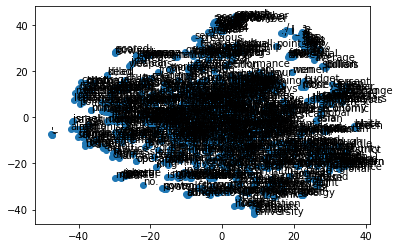

In [7]:
tsne = TSNE(n_components=2, random_state=0)
words =  list(embeddings_dict.keys())
vectors = [embeddings_dict[word] for word in words]
Y = tsne.fit_transform(vectors[:1000])
plt.scatter(Y[:, 0], Y[:, 1])

for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

In [19]:
all_text = train_feats['text'].tolist()

vectorizer = TfidfVectorizer(max_features=100, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(all_text).toarray()

In [20]:
# Drop text (JUST FOR A TEST)
train_feats = train_feats.drop(['text'], axis=1)
train_feats = train_feats.drop(['weekday'], axis=1)

In [29]:
# Get data ready
# Get sentiment
labels = train_feats['sentiment']
# Drop labels from larger dataframee
train_feats = train_feats.drop(['sentiment'], axis=1)

# Convert both to numpy arrays
#non_text_feats = train_feats.to_numpy()
#X = np.concatenate((processed_features, non_text_feats), axis=1)
X = processed_features
y = labels.to_numpy()

KeyError: 'sentiment'

In [30]:
# Instantiate model - Multinomial logistic regression
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train model
model.fit(X, y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [31]:
y_preds = model.predict(X)
# Print score
print(f1_score(y, y_preds, average='micro'))

0.6274510473219177
